# Forest Cover Map
Input: 
- Forest4model_v1_Forest_cover

Aim:
- Visualising forest cover in sample countries
- Calculating total forest cover map in EU countries

Output:
- A dataframe containing total area of forest cover in 32 EU countries

In [1]:
# Vector data
import geopandas as gpd
from shapely.geometry import mapping

# Tabular data
import pandas as pd
import numpy as np

# Raster array
import xarray as xr
import rioxarray as rio
from rasterio.enums import Resampling

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# System
from pathlib import Path
import os
import copy
import json

# Import functions from geo_tools module
from geo_tools import utils, plot_iso_forest

# Reloads module
%load_ext autoreload
%autoreload 2

# Output directory

In [2]:
# Specify the desired output folder path for processed dataset
output_data_dir = Path.cwd() / ".." / "output_data"

# Check if the output folder exists, and create if not
Path.mkdir(output_data_dir, exist_ok=True, parents=True)

In [3]:
# Specify the desired output folder path for figures
output_figure_dir = Path.cwd() / ".." / "output_figures"

# Check if the output folder exists, and create if not
Path.mkdir(output_figure_dir, exist_ok=True, parents=True)

# A list of ISO3 codes of EU countries

In [4]:
eu_iso3 = pd.read_csv(output_data_dir/"Country_Codes_and_Names_ISO3.csv")

eu_iso = eu_iso3["ISO3"]

# Plotting forest cover in DEU

###  Clip the data to ISO border and export the raster

In [5]:
%%time

from IPython.display import clear_output

for count, iso in enumerate(eu_iso):
    clear_output(wait=True)

    # Clip the forest cover and border data for the specified ISO code
    forest_cover, border = utils.clip_array(iso, "Forest_cover")

    # Remove the 'grid_mapping' attribute if it exists
    if "grid_mapping" in forest_cover.attrs:
        del forest_cover.attrs["grid_mapping"]

    # # Export the border as a shapefile
    # border.to_file(output_figure_dir / f"{iso}" / f"{iso}_border.shp")

    # # Export raster with EPSG:4326 to .tif
    # forest_cover.rio.to_raster(output_figure_dir/f"{iso}"/f"{iso}_forest_cover.tif")

    # # Reproject to Plate Carree if needed
    # raster_h = forest_cover.rio.height
    # raster_w = forest_cover.rio.width

    # forest_cover_proj = forest_cover.rio.reproject(
    #     "EPSG:32662",
    #     resampling=Resampling.nearest
    # )

    # # Export raster with Plate Carree projection EPSG:32662 to .tif
    # forest_cover_proj.rio.to_raster(output_figure_dir/f"{iso}"/f"{iso}_forest_cover_Plate_Carree.tif")

    print(
        f"Clipped .netcdf files for Forest_cover is saved for {iso} in output_figures/{iso}"
    )

    print(
        "Clipping progress for all EU countries:",
        np.round((count + 1) / len(eu_iso) * 100, 2),
        "%",
    )

    forest_cover.close()

CRS information for the raster is missing. Clipping and reprojecting the raster to match the CRS of the boundary shapefile
CRS for the clipped raster is set to EPSG:4326
CRS for the boundary shapefile is set to 4326
Clipped .netcdf files for Forest_cover is saved for GBR in output_figures/GBR
Clipping progress for all EU countries: 100.0 %
CPU times: user 41.7 s, sys: 7.57 s, total: 49.3 s
Wall time: 49.3 s


### Plotting

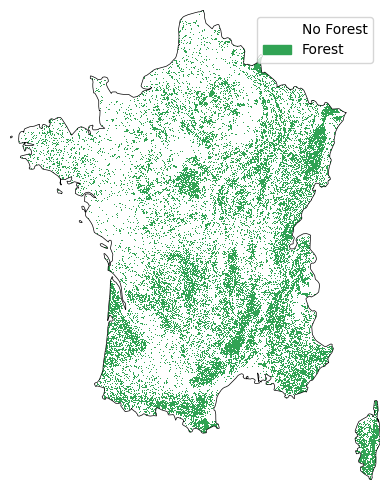

In [14]:
# Takes values > 0
non_zero = forest_cover.where(forest_cover > 0)

# Plot template
figure, ax = plt.subplots(figsize=(4,5))

# Create a custom discrete colormap
cmap = mcolors.ListedColormap(["#FFFFFF", "#31a354"])
bounds = [0.0, 0.5, 1.5]  # Define the boundaries for the colormap
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create legend handles
tick_labels = ['No Forest', 'Forest']
handles = [mpatches.Patch(color=cmap(pos), label=f"{tick}") for pos, tick in zip(bounds, tick_labels)]

# Plot administration border
border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

# Plot forest cover map
ax_p = non_zero.plot.imshow(cmap=cmap, norm=norm, ax=ax, add_colorbar=False)

# # Add a color bar
# cbar = figure.colorbar(ax_p, ticks=[0.25, 1])
# cbar.ax.set_yticklabels(tick_labels)
# cbar.set_label('Forest cover')

# Add the legend with custom handles
ax.legend(handles=handles)

# Get the year automatically
year = non_zero.time.dt.year.item()

# Additional information
ax.axis("off")
ax.set(title=None)

# xarray_title = "Forest cover"
# ax.set(title=f"{xarray_title} in DEU in {year}")
plt.tight_layout()

# # Export the plot
# plt.savefig(output_figure_dir/"deu_forest_cover.png")

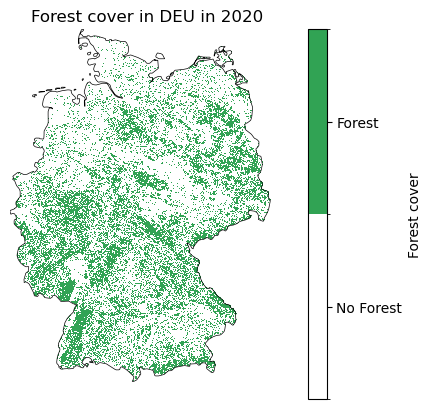

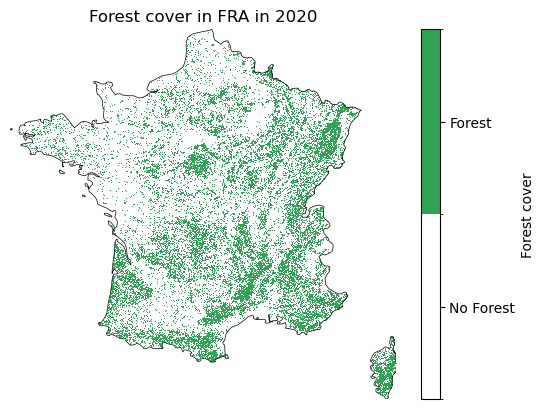

In [11]:
# Testing plot_iso_forest for many countries at once
for iso in ["DEU", "FRA"]:
    plot_iso_forest.plot_forest(
        iso_code=iso,
        xarray_id="Forest_cover"
    )

# Calculating area

In [8]:
%%time

forest_cover = []
for eu in eu_iso:
    iso_forest_cover = plot_iso_forest.agg_total_area(
        iso_code=eu, 
        xarray_id="Forest_cover", 
        forest_layer_year=2020,
    )

    forest_cover.append(iso_forest_cover)

CPU times: user 42.7 s, sys: 10.3 s, total: 53 s
Wall time: 5min 47s


In [16]:
forest_cover_df = pd.concat(forest_cover)

In [18]:
# Export as a CSV
forest_cover_df.to_csv(output_data_dir/"iso_forest_cover_stats.csv")

In [ ]:
# For utils.clip_array
# print(f"CRS of the country borders: {border.crs}")

# if forest_cover.rio.crs is None:
#     forest_cover = forest_cover.rio.write_crs(border.crs)
#     print(f"The raster for the forest cover does not have a crs. Assigned the following CRS to the raster: {forest_cover.rio.crs}")

# else:
#     print(f"The raster has a CRS assigned for the forest cover data: {forest_cover.rio.crs}")

# Sandbox

### Conversion from netcdf to geojson (1)

In [ ]:
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# Specify the ISO code for Germany
iso = "DEU"
netcdf_file_path = output_figure_dir / f"{iso}" / f"{iso}_forest_cover.nc"
geojson_file_path = output_figure_dir / f"{iso}" / f"{iso}_forest_cover.geojson"

# Load the NetCDF file
forest_cover_data = xr.open_dataset(netcdf_file_path)

# Assuming 'forest_cover' is the name of the variable in the NetCDF file
# Adjust 'forest_cover' to the actual variable name if it's different
forest_cover = forest_cover_data['Forest_cover']

# Get coordinates
latitudes = forest_cover.coords['latitude'].values
longitudes = forest_cover.coords['longitude'].values

# Create a meshgrid of coordinates
lon, lat = np.meshgrid(longitudes, latitudes)

# Flatten the arrays
lon_flat = lon.flatten()
lat_flat = lat.flatten()
forest_cover_flat = forest_cover.values.flatten()

# Create a DataFrame for the points
data = {
    'longitude': lon_flat,
    'latitude': lat_flat,
    'Forest_cover': forest_cover_flat
}

# Create GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=[Point(xy) for xy in zip(lon_flat, lat_flat)],
    crs="EPSG:32662"  # Use the appropriate CRS for your data
)

# Remove rows with NaN values in forest_cover
gdf = gdf[gdf['Forest_cover'].notna()]

# Save GeoDataFrame to GeoJSON
gdf.to_file(geojson_file_path, driver='GeoJSON')

print(f"GeoJSON file is saved for {iso} at {geojson_file_path}")

# Close the dataset
forest_cover_data.close()


### Conversion from netcdf to geojson (2)

In [ ]:
import xarray as xr
import geopandas as gpd
import numpy as np
import json
from shapely.geometry import Point

# Specify the ISO code for Germany
iso = "DEU"
netcdf_file_path = output_figure_dir / f"{iso}" / f"{iso}_forest_cover.nc"
geojson_file_path = output_figure_dir / f"{iso}" / f"{iso}_forest_cover.geojson"

# Load the NetCDF file
forest_cover_data = xr.open_dataset(netcdf_file_path)

# Assuming 'forest_cover' is the name of the variable in the NetCDF file
# Adjust 'forest_cover' to the actual variable name if it's different
forest_cover = forest_cover_data['Forest_cover']

# Get coordinates (latitude and longitude)
latitudes = forest_cover.coords['latitude'].values
longitudes = forest_cover.coords['longitude'].values

# Create a meshgrid of coordinates
lon, lat = np.meshgrid(longitudes, latitudes)

# Flatten the arrays for simplicity
lon_flat = lon.flatten()
lat_flat = lat.flatten()
forest_cover_flat = forest_cover.values.flatten()

# Create a list to store the reduced GeoJSON data
geojson_features = []

# Iterate through all values to build the simplified GeoJSON structure
for i in range(len(forest_cover_flat)):
    # Get the forest cover value for this point
    forest_value = forest_cover_flat[i]

    # Include only points with valid forest cover values
    if not np.isnan(forest_value):
        # Create a feature for each valid point
        feature = {
            "type": "Feature",
            "properties": {
                "ISO_code": iso,  # Include the ISO code
                "forest_cover": float(forest_value)  # Forest cover value
            },
            "geometry": {
                "type": "Point",
                "coordinates": [float(lon_flat[i]), float(lat_flat[i])]  # Coordinate origin
            }
        }
        geojson_features.append(feature)

# Create the final GeoJSON structure
geojson_data = {
    "type": "FeatureCollection",
    "features": geojson_features
}

# Save the reduced GeoJSON data to a file
with open(geojson_file_path, 'w') as f:
    json.dump(geojson_data, f)

print(f"Reduced GeoJSON file is saved for {iso} at {geojson_file_path}")

# Close the dataset
forest_cover_data.close()


### Conversion from NetCDF to Geotiff 

In [ ]:
# To be adapted when raster file is needed for web development
for iso in ["DEU"]:
    # Clip the forest cover and border data for the specified ISO code
    forest_cover, border = utils.clip_array(iso, "Forest_cover")

    
    # # Remove the 'grid_mapping' attribute if it exists
    if 'grid_mapping' in forest_cover.attrs:
         del forest_cover.attrs['grid_mapping']

    # # Export raster with EPSG:4326 to .tif
    forest_cover.rio.to_raster(output_figure_dir/f"{iso}"/f"{iso}_forest_cover.tif")

    # # Export border as a shp
    border.to_file(output_figure_dir/f"{iso}"/f"{iso}_border.shp")

    # # Reproject to Plate Carree if needed
    raster_h = forest_cover.rio.height
    raster_w = forest_cover.rio.width

    forest_cover_proj = forest_cover.rio.reproject(
        "EPSG:32662",
        resampling=Resampling.nearest
    )

    # # Export raster with Plate Carree projection EPSG:32662 to .tif
    forest_cover_proj.rio.to_raster(output_figure_dir/f"{iso}"/f"{iso}_forest_cover_Plate_Carree.tif")

    print(f"Clipped .netcdf files for Forest_cover is saved for {iso} in output_figures/{iso}")

    forest_cover.close()

### Conversion from geotiff to geojson

In [ ]:
tiff_name = '/mnt/PROVIDE/firzar/forest_data_analysis/output_figures/DEU/DEU_forest_cover.tif'

In [ ]:
import rasterio
data = rasterio.open(tiff_name).meta
data

In [ ]:
c = str(data['crs'])
c_s = c.split(':')
c_s[1]

In [ ]:
import rasterio
from rasterio.features import shapes
mask = None
with rasterio.open(tiff_name) as src:
    image = src.read(1) # first band
    results = (
    {'properties': {'Forest_cover': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, transform=data['transform'])))

In [ ]:
geoms = list(results)

In [ ]:
import geopandas as gp
gpd_polygonized_raster  = gp.GeoDataFrame.from_features(geoms, crs=c)

In [ ]:
gpd_polygonized_raster = gpd_polygonized_raster[gpd_polygonized_raster['Forest_cover']>0]

In [ ]:
gpd_polygonized_raster

In [ ]:
crs_sys = 'epsg:'+c_s[1]
crs_sys

In [ ]:
gpd_polygonized_raster['geometry'] = gpd_polygonized_raster['geometry'].to_crs({'init': crs_sys})

In [ ]:
gpd_polygonized_raster.to_file('/mnt/PROVIDE/firzar/forest_data_analysis/output_figures/DEU/DEU_forest_cover.geojson', driver='GeoJSON') 

### Creating json file out of netcdf dataset 

In [3]:
import xarray as xr

# Path to your NetCDF file
forest_cover_path = "/mnt/PROVIDE/firzar/forest_data/raw_data/Forest4model_v1_Forest_cover.nc"

# Open the NetCDF file
ds = xr.open_dataset(forest_cover_path)

# Print the dataset information to see its variables and dimensions
print(ds)

# Optionally, print variable names and their attributes
for var_name in ds.data_vars:
    print(f"Variable: {var_name}")
    print(ds[var_name].attrs)  # Print attributes of each variable

# Close the dataset
ds.close()


<xarray.Dataset>
Dimensions:       (time: 1, latitude: 37778, longitude: 101055)
Coordinates:
  * latitude      (latitude) float64 72.66 72.66 72.66 ... 24.29 24.29 24.29
  * longitude     (longitude) float64 -56.5 -56.5 -56.5 ... 72.9 72.9 72.91
  * time          (time) datetime64[ns] 2020-01-01
Data variables:
    Forest_cover  (time, latitude, longitude) float32 ...
Attributes:
    contact_email:          besnard@gfz-potsdam.de and runge@gfz-potsdam.de
    creator:                Simon Besnard and Alexandra Runge
    geographical_coverage:  Europe
    institution:            GFZ-Potsdam
    license:                Publicly available
    project:                ForestNavigator: Navigating European forests and ...
    references:             https://www.forestnavigator.eu/
    spatial_exent:          longitude_max: 72.90546463, latitude_max: 72.6626...
    spatial_resolution:     100m pixel size
    summary:                A datacube with data layers that describe EU fore...
    tempo

In [1]:
for iso in ["DEU"]:
    # Clip the forest cover and border data for the specified ISO code
    forest_cover, border = utils.clip_array(iso, "Forest_cover")

    # Remove the 'grid_mapping' attribute if it exists
    if 'grid_mapping' in forest_cover.attrs:
        del forest_cover.attrs['grid_mapping']

    # Export the forest cover data as a NetCDF file
    forest_cover.rio.to_netcdf(output_figure_dir / f"{iso}" / f"{iso}_forest_cover.nc")

    # Export the border as a shapefile
    border.to_file(output_figure_dir / f"{iso}" / f"{iso}_border.shp")

    print(f"NetCDF file for Forest_cover is saved for {iso} in output_figures/{iso}")

    # Close the forest cover dataset
    forest_cover.close()


NameError: name 'utils' is not defined